In [ ]:
!pip install xgboost
!pip install xgboost scikit-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

In [2]:
from google.colab import files
uploaded = files.upload()

Saving METABRIC_RNA_Mutation.csv to METABRIC_RNA_Mutation.csv


In [ ]:
import pandas as pd

file_path = "METABRIC_RNA_Mutation.csv" 
df = pd.read_csv(file_path)

target_col = "pam50_+_claudin-low_subtype"
clinical_cols = ["age_at_diagnosis", "hormone_therapy", "tumor_size"]

gene_expression_cols = [col for col in df.columns if col.islower() and not col.endswith("_mut")]

mutation_cols = [col for col in df.columns if col.endswith("_mut")]

final_columns = [target_col] + clinical_cols + gene_expression_cols + mutation_cols

df_filtered = df[final_columns].copy()

df_filtered["tumor_size"].fillna(df_filtered["tumor_size"].median(), inplace=True)

df_filtered.to_csv("cleaned_METABRIC.csv", index=False)

print("✅ Dataset cleaned and saved as 'cleaned_METABRIC.csv'")


<ipython-input-3-0a5c905ddf72>:5: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-3-0a5c905ddf72>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["tumor_size"].fillna(df_filtered["tumor_size"].median(), inplace=True)


✅ Dataset cleaned and saved as 'cleaned_METABRIC.csv'


In [ ]:

unwanted_columns = [
    "patient_id", "age_at_diagnosis", "type_of_breast_surgery", "cancer_type",
    "cancer_type_detailed", "cellularity", "chemotherapy", "cohort",
    "er_status_measured_by_ihc", "er_status", "neoplasm_histologic_grade",
    "her2_status_measured_by_snp6", "her2_status", "tumor_other_histologic_subtype",
    "hormone_therapy", "inferred_menopausal_state", "integrative_cluster",
    "primary_tumor_laterality", "lymph_nodes_examined_positive", "mutation_count",
    "nottingham_prognostic_index", "oncotree_code", "overall_survival_months",
    "overall_survival", "pr_status", "radio_therapy",
    "3-gene_classifier_subtype", "tumor_stage", "death_from_cancer"
]
columns_to_drop = [col for col in unwanted_columns if col in df.columns]
df_cleaned = df.drop(columns=columns_to_drop)

print("Shape after cleaning:", df_cleaned.shape)
print("Remaining columns:", df_cleaned.columns[:20].tolist())
print(df_cleaned.head())

Shape after cleaning: (1904, 664)
Remaining columns: ['pam50_+_claudin-low_subtype', 'tumor_size', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c']
  pam50_+_claudin-low_subtype  tumor_size   brca1   brca2   palb2    pten  \
0                 claudin-low        22.0 -1.3990 -0.5738 -1.6217  1.4524   
1                        LumA        10.0 -1.3800  0.2777 -1.2154  0.5296   
2                        LumB        15.0  0.0670 -0.8426  0.2114 -0.3326   
3                        LumB        25.0  0.6744 -0.5428 -1.6592  0.6369   
4                        LumB        40.0  1.2932 -0.9039 -0.7219  0.2168   

     tp53     atm    cdh1   chek2  ...  mtap_mut  ppp2cb_mut  smarcd1_mut  \
0  0.3504  1.1517  0.0348  0.1266  ...         0           0            0   
1 -0.0136 -0.2659  1.3594  0.7961  ...         0           0            0   
2  0.5141 -0.0803  1.1398  0.4187  ...         0         

In [ ]:
columns_to_check = [
    'pam50_+_claudin-low_subtype', 'tumor_size', 'brca1', 'brca2', 'palb2', 'pten',
    'tp53', 'atm', 'cdh1', 'chek2', 'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut',
    'nras_mut', 'ndfip1_mut', 'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'
]

missing = df[columns_to_check].isnull().sum()

print(missing[missing > 0])


tumor_size    20
dtype: int64


In [6]:
df['tumor_size'].fillna(df['tumor_size'].median(), inplace=True)


<ipython-input-6-8da7b2bc20f5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['tumor_size'].fillna(df['tumor_size'].median(), inplace=True)


In [7]:
print("Missing values in each column:")
print(df_cleaned.isnull().sum())


Missing values in each column:
pam50_+_claudin-low_subtype     0
tumor_size                     20
brca1                           0
brca2                           0
palb2                           0
                               ..
hras_mut                        0
prps2_mut                       0
smarcb1_mut                     0
stmn2_mut                       0
siah1_mut                       0
Length: 664, dtype: int64


In [8]:
print(df['tumor_size'].isnull().sum())


0


In [9]:
print(df_cleaned.info())
print(df_cleaned.dtypes)
mutation_cols = [col for col in df_cleaned.columns if 'mutation' in col.lower()]
print("Mutation columns:", mutation_cols)
print(df_cleaned[mutation_cols].dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Columns: 664 entries, pam50_+_claudin-low_subtype to siah1_mut
dtypes: float64(490), object(174)
memory usage: 9.6+ MB
None
pam50_+_claudin-low_subtype     object
tumor_size                     float64
brca1                          float64
brca2                          float64
palb2                          float64
                                ...   
hras_mut                        object
prps2_mut                       object
smarcb1_mut                     object
stmn2_mut                       object
siah1_mut                       object
Length: 664, dtype: object
Mutation columns: []
Series([], dtype: object)


In [10]:
mutation_cols = [col for col in df_cleaned.columns if col.endswith('_mut')]
print("Mutation columns:", mutation_cols)


Mutation columns: ['pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut', 'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'cdh1_mut', 'dnah2_mut', 'kmt2d_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut', 'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut', 'utrn_mut', 'tbx3_mut', 'col6a3_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut', 'ncor2_mut', 'col12a1_mut', 'col22a1_mut', 'pten_mut', 'akt1_mut', 'atr_mut', 'thada_mut', 'ncor1_mut', 'stab2_mut', 'myh9_mut', 'runx1_mut', 'nf1_mut', 'map2k4_mut', 'ros1_mut', 'lamb3_mut', 'arid1b_mut', 'erbb2_mut', 'sf3b1_mut', 'shank2_mut', 'ep300_mut', 'ptprd_mut', 'usp9x_mut', 'setd2_mut', 'setd1a_mut', 'thsd7a_mut', 'afdn_mut', 'erbb3_mut', 'rb1_mut', 'myo1a_mut', 'alk_mut', 'fanca_mut', 'adgra2_mut', 'ubr5_mut', 'pik3r1_mut', 'myo3a_mut', 'asxl2_mut', 'apc_mut', 'ctcf_mut', 'asxl1_mut', 'fancd2_mut', 'taf1_mut', 'kdm6a_mut', 'ctnna3_mut', 'brca1_mut', 'ptprm_mut', 'foxo3_mut', 'usp28_mut', 'gldc_mut',

In [ ]:
for col in mutation_cols[:5]: 
    print(f"{col} unique values: {df_cleaned[col].unique()}")


pik3ca_mut unique values: ['0' 'H1047R' 'E542K' 'Q546H G1049R' 'E545K' 'N345K E81K' 'H1047L E726K'
 'H1047L' 'E545Q' 'N345K' 'L452Kfs*4 E453Dfs*7' 'N345K N1044K'
 'E365K C420R' 'E545K H1047R' 'E542K E726K' 'E453_L455del' 'G451_D454del'
 'E110del' 'Q546K' 'H1047R E453K' 'R88Q' 'H1047R P104L' 'H1047R E726K'
 'M1043V' 'Q546P' 'N1068Kfs*5' 'H1047R R108H' 'K111E' 'H1047R G118D'
 'H1047R H1048R' 'E545G' 'E542K N345K' 'E545K G320A' 'E545K S509Y' 'E418K'
 'E545K G914R' 'H1047R L10_P17del' 'C420R' 'P449S' 'E545K E726K'
 'H1047R E81K' 'Q546R' 'H1047R D1029H H1048R' 'E545K M1043V' 'P449T'
 'V105del K148N' 'A1066Cfs*7' 'H1047R T727K' 'E545A' 'H1047R E80K' 'E726K'
 'H1047L E385K' 'H1047R K111E' 'E542K T727K' 'M1043I' 'H1047R P471L'
 'E726K P449_L452del' 'G118D' 'N345K M1043I' 'Y1021Hfs*9' 'P447_L455del'
 'Q546H' 'Q546R E453K' 'E542K Y1021H' 'R108del' 'M1043V E726K'
 'E545K D725N' 'H1047R E365K' '*1069Lfs*5' 'E453_G460delinsD' 'H1047Y'
 'E542K D1045N Q1064H' 'R88Q H1047R' 'H450_I459del' 'F909L' 'H10

In [12]:
print(df_cleaned.columns.tolist())


['pam50_+_claudin-low_subtype', 'tumor_size', 'brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1', 'stk11', 'bard1', 'mlh1', 'msh2', 'msh6', 'pms2', 'epcam', 'rad51c', 'rad51d', 'rad50', 'rb1', 'rbl1', 'rbl2', 'ccna1', 'ccnb1', 'cdk1', 'ccne1', 'cdk2', 'cdc25a', 'ccnd1', 'cdk4', 'cdk6', 'ccnd2', 'cdkn2a', 'cdkn2b', 'myc', 'cdkn1a', 'cdkn1b', 'e2f1', 'e2f2', 'e2f3', 'e2f4', 'e2f5', 'e2f6', 'e2f7', 'e2f8', 'src', 'jak1', 'jak2', 'stat1', 'stat2', 'stat3', 'stat5a', 'stat5b', 'mdm2', 'tp53bp1', 'adam10', 'adam17', 'aph1a', 'aph1b', 'arrdc1', 'cir1', 'ctbp1', 'ctbp2', 'cul1', 'dll1', 'dll3', 'dll4', 'dtx1', 'dtx2', 'dtx3', 'dtx4', 'ep300', 'fbxw7', 'hdac1', 'hdac2', 'hes1', 'hes5', 'heyl', 'itch', 'jag1', 'jag2', 'kdm5a', 'lfng', 'maml1', 'maml2', 'maml3', 'ncor2', 'ncstn', 'notch1', 'notch2', 'notch3', 'nrarp', 'numb', 'numbl', 'psen1', 'psen2', 'psenen', 'rbpj', 'rbpjl', 'rfng', 'snw1', 'spen', 'hes2', 'hes4', 'hes7', 'hey1', 'hey2', 'acvr1', 'acvr1b', 'acvr1c

In [ ]:

for i, col in enumerate(df_cleaned.columns):
    print(f"{i}: '{col}'")



0: 'pam50_+_claudin-low_subtype'
1: 'tumor_size'
2: 'brca1'
3: 'brca2'
4: 'palb2'
5: 'pten'
6: 'tp53'
7: 'atm'
8: 'cdh1'
9: 'chek2'
10: 'nbn'
11: 'nf1'
12: 'stk11'
13: 'bard1'
14: 'mlh1'
15: 'msh2'
16: 'msh6'
17: 'pms2'
18: 'epcam'
19: 'rad51c'
20: 'rad51d'
21: 'rad50'
22: 'rb1'
23: 'rbl1'
24: 'rbl2'
25: 'ccna1'
26: 'ccnb1'
27: 'cdk1'
28: 'ccne1'
29: 'cdk2'
30: 'cdc25a'
31: 'ccnd1'
32: 'cdk4'
33: 'cdk6'
34: 'ccnd2'
35: 'cdkn2a'
36: 'cdkn2b'
37: 'myc'
38: 'cdkn1a'
39: 'cdkn1b'
40: 'e2f1'
41: 'e2f2'
42: 'e2f3'
43: 'e2f4'
44: 'e2f5'
45: 'e2f6'
46: 'e2f7'
47: 'e2f8'
48: 'src'
49: 'jak1'
50: 'jak2'
51: 'stat1'
52: 'stat2'
53: 'stat3'
54: 'stat5a'
55: 'stat5b'
56: 'mdm2'
57: 'tp53bp1'
58: 'adam10'
59: 'adam17'
60: 'aph1a'
61: 'aph1b'
62: 'arrdc1'
63: 'cir1'
64: 'ctbp1'
65: 'ctbp2'
66: 'cul1'
67: 'dll1'
68: 'dll3'
69: 'dll4'
70: 'dtx1'
71: 'dtx2'
72: 'dtx3'
73: 'dtx4'
74: 'ep300'
75: 'fbxw7'
76: 'hdac1'
77: 'hdac2'
78: 'hes1'
79: 'hes5'
80: 'heyl'
81: 'itch'
82: 'jag1'
83: 'jag2'
84: 'kdm5a'


In [14]:
[col for col in df_cleaned.columns if 'pik3ca' in col.lower()]


['pik3ca', 'pik3ca_mut']

In [ ]:

mutation_cols = [col for col in df.columns if col.endswith('_mut')]

df[mutation_cols] = df[mutation_cols].notnull().astype(int)

print(df[mutation_cols].head())


   pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  kmt2c_mut  syne1_mut  \
0           1         1          1           1          1          1   
1           1         1          1           1          1          1   
2           1         1          1           1          1          1   
3           1         1          1           1          1          1   
4           1         1          1           1          1          1   

   gata3_mut  map3k1_mut  ahnak_mut  dnah11_mut  ...  mtap_mut  ppp2cb_mut  \
0          1           1          1           1  ...         1           1   
1          1           1          1           1  ...         1           1   
2          1           1          1           1  ...         1           1   
3          1           1          1           1  ...         1           1   
4          1           1          1           1  ...         1           1   

   smarcd1_mut  nras_mut  ndfip1_mut  hras_mut  prps2_mut  smarcb1_mut  \
0            1         1

In [16]:
print(df_cleaned[mutation_cols].head())


  pik3ca_mut tp53_mut muc16_mut ahnak2_mut kmt2c_mut syne1_mut gata3_mut  \
0          0        0         0          0         0         0         0   
1          0    H178P         0          0         0         0         0   
2     H1047R        0         0          0         0         0         0   
3      E542K        0         0          0         0         0         0   
4          0    S241F         0          0         0         0         0   

  map3k1_mut ahnak_mut dnah11_mut  ... mtap_mut ppp2cb_mut smarcd1_mut  \
0          0         0          0  ...        0          0           0   
1          0         0          0  ...        0          0           0   
2          0         0          0  ...        0          0           0   
3          0         0          0  ...        0          0           0   
4          0         0          0  ...        0          0           0   

  nras_mut ndfip1_mut hras_mut prps2_mut smarcb1_mut stmn2_mut siah1_mut  
0        0          0  

In [ ]:
import pandas as pd

mutation_columns = [
    'pik3ca_mut', 'tp53_mut', 'muc16_mut', 'ahnak2_mut', 'kmt2c_mut', 'syne1_mut',
    'gata3_mut', 'map3k1_mut', 'ahnak_mut', 'dnah11_mut', 'mtap_mut', 'ppp2cb_mut',
    'smarcd1_mut', 'nras_mut', 'ndfip1_mut', 'hras_mut', 'prps2_mut',
    'smarcb1_mut', 'stmn2_mut', 'siah1_mut'
]

def encode_mutation(value):
    return 0 if value in [0, "0", "", None] else 1

existing_mutation_columns = [col for col in mutation_columns if col in df_cleaned.columns]

for col in existing_mutation_columns:
    df_cleaned[col] = df_cleaned[col].apply(encode_mutation)

print(df_cleaned[existing_mutation_columns].head())

missing_columns = [col for col in mutation_columns if col not in df_cleaned.columns]
if missing_columns:
    print("\nMissing columns (not in DataFrame):")
    print(missing_columns)


   pik3ca_mut  tp53_mut  muc16_mut  ahnak2_mut  kmt2c_mut  syne1_mut  \
0           0         0          0           0          0          0   
1           0         1          0           0          0          0   
2           1         0          0           0          0          0   
3           1         0          0           0          0          0   
4           0         1          0           0          0          0   

   gata3_mut  map3k1_mut  ahnak_mut  dnah11_mut  mtap_mut  ppp2cb_mut  \
0          0           0          0           0         0           0   
1          0           0          0           0         0           0   
2          0           0          0           0         0           0   
3          0           0          0           0         0           0   
4          0           0          0           0         0           0   

   smarcd1_mut  nras_mut  ndfip1_mut  hras_mut  prps2_mut  smarcb1_mut  \
0            0         0           0         0        

In [ ]:

for col in existing_mutation_columns:
    unique_vals = df_cleaned[col].unique()
    if set(unique_vals).issubset({0, 1}):
        print(f"{col}: ✅ All values are encoded correctly (0/1)")
    else:
        print(f"{col}: ❌ Unexpected values found -> {unique_vals}")


pik3ca_mut: ✅ All values are encoded correctly (0/1)
tp53_mut: ✅ All values are encoded correctly (0/1)
muc16_mut: ✅ All values are encoded correctly (0/1)
ahnak2_mut: ✅ All values are encoded correctly (0/1)
kmt2c_mut: ✅ All values are encoded correctly (0/1)
syne1_mut: ✅ All values are encoded correctly (0/1)
gata3_mut: ✅ All values are encoded correctly (0/1)
map3k1_mut: ✅ All values are encoded correctly (0/1)
ahnak_mut: ✅ All values are encoded correctly (0/1)
dnah11_mut: ✅ All values are encoded correctly (0/1)
mtap_mut: ✅ All values are encoded correctly (0/1)
ppp2cb_mut: ✅ All values are encoded correctly (0/1)
smarcd1_mut: ✅ All values are encoded correctly (0/1)
nras_mut: ✅ All values are encoded correctly (0/1)
ndfip1_mut: ✅ All values are encoded correctly (0/1)
hras_mut: ✅ All values are encoded correctly (0/1)
prps2_mut: ✅ All values are encoded correctly (0/1)
smarcb1_mut: ✅ All values are encoded correctly (0/1)
stmn2_mut: ✅ All values are encoded correctly (0/1)
siah1_

In [19]:
print("\nColumn data types:")
print(df_cleaned[existing_mutation_columns].dtypes)



Column data types:
pik3ca_mut     int64
tp53_mut       int64
muc16_mut      int64
ahnak2_mut     int64
kmt2c_mut      int64
syne1_mut      int64
gata3_mut      int64
map3k1_mut     int64
ahnak_mut      int64
dnah11_mut     int64
mtap_mut       int64
ppp2cb_mut     int64
smarcd1_mut    int64
nras_mut       int64
ndfip1_mut     int64
hras_mut       int64
prps2_mut      int64
smarcb1_mut    int64
stmn2_mut      int64
siah1_mut      int64
dtype: object


In [ ]:
X = df_cleaned.drop('pam50_+_claudin-low_subtype', axis=1)
y = df_cleaned['pam50_+_claudin-low_subtype']  


In [ ]:
import numpy as np

class_counts = np.unique(y, return_counts=True)
print("Class distribution (class, count):")
print(dict(zip(class_counts[0], class_counts[1])))


Class distribution (class, count):
{'Basal': np.int64(199), 'Her2': np.int64(220), 'LumA': np.int64(679), 'LumB': np.int64(461), 'NC': np.int64(6), 'Normal': np.int64(140), 'claudin-low': np.int64(199)}


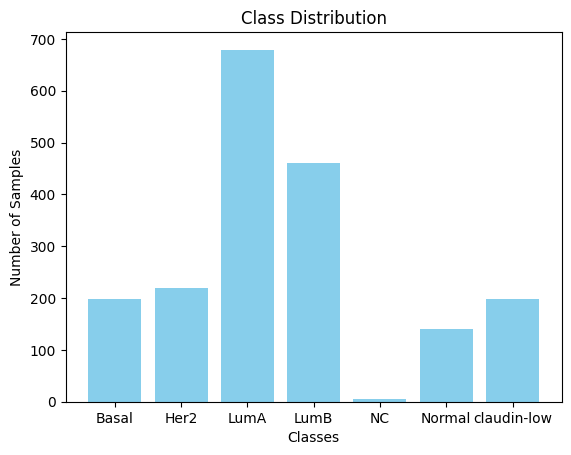

In [ ]:
import matplotlib.pyplot as plt

plt.bar(class_counts[0], class_counts[1], color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
from sklearn.utils import resample

balanced_df = df_cleaned[df_cleaned['pam50_+_claudin-low_subtype'] != 'NC']

resampled_classes = []

classes = balanced_df['pam50_+_claudin-low_subtype'].unique()

for class_label in classes:
    class_data = balanced_df[balanced_df['pam50_+_claudin-low_subtype'] == class_label]

    if len(class_data) < 400:
        resampled_class = resample(class_data,
                                   replace=True,     
                                   n_samples=400,    
                                   random_state=42)  
    else:
        resampled_class = resample(class_data,
                                   replace=False,   
                                   n_samples=400,    
                                   random_state=42)  

    resampled_classes.append(resampled_class)

balanced_df = pd.concat(resampled_classes)

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['pam50_+_claudin-low_subtype'].value_counts())


pam50_+_claudin-low_subtype
Basal          400
Normal         400
LumB           400
claudin-low    400
Her2           400
LumA           400
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer

X = df_cleaned.drop('pam50_+_claudin-low_subtype', axis=1)  
y = df_cleaned['pam50_+_claudin-low_subtype']  
label_encoder = LabelEncoder()

categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
    X[col] = X[col].astype(str)
    X[col] = label_encoder.fit_transform(X[col])

imputer = SimpleImputer(strategy='median') 
X_imputed = imputer.fit_transform(X) 

X_columns = X.columns

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y) 

lasso = Lasso(alpha=0.1)  
lasso.fit(X_imputed, y)
selected_features = X_columns[lasso.coef_ != 0]
print("Selected features:", selected_features)

Selected features: Index(['pten', 'msh6', 'rbl2', 'cdc25a', 'cdkn2a', 'cdkn2b', 'stat5b', 'mdm2',
       'aph1b', 'arrdc1', 'hes1', 'rbpj', 'hes4', 'acvrl1', 'braf', 'egfr',
       'erbb2', 'folr2', 'mmp15', 'ptk2', 'rab25', 'smad3', 'tgfbr2', 'vegfa',
       'pde4dip', 'abcb1', 'slco1b3', 'ahnak', 'chd1', 'klrg1', 'lifr', 'mtap',
       'nr3c1', 'nt5e', 'cdkn2c', 'cyp11a1', 'hsd17b4', 'nrip1', 'srd5a1',
       'cdh1_mut', 'dnah2_mut', 'ush2a_mut', 'ryr2_mut', 'dnah5_mut',
       'herc2_mut', 'pde4dip_mut', 'akap9_mut', 'tg_mut', 'birc6_mut',
       'utrn_mut', 'arid1a_mut', 'lama2_mut', 'notch1_mut', 'cbfb_mut',
       'ncor2_mut', 'col22a1_mut', 'pten_mut', 'thada_mut', 'ncor1_mut',
       'stab2_mut', 'myh9_mut', 'runx1_mut', 'map2k4_mut', 'ros1_mut',
       'arid1b_mut', 'setd2_mut', 'thsd7a_mut', 'afdn_mut', 'erbb3_mut',
       'ubr5_mut', 'asxl2_mut', 'ctcf_mut', 'ctnna3_mut', 'brca1_mut',
       'brca2_mut', 'lifr_mut', 'chd1_mut'],
      dtype='object')


In [ ]:

X_selected = pd.DataFrame(X_imputed, columns=X_columns)[selected_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


In [37]:
from sklearn.model_selection import train_test_split

X = balanced_df.drop(columns=['pam50_+_claudin-low_subtype'])
y = balanced_df['pam50_+_claudin-low_subtype']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

X = balanced_df.drop('pam50_+_claudin-low_subtype', axis=1)
y = balanced_df['pam50_+_claudin-low_subtype']

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

categorical_cols = X.select_dtypes(include=['object']).columns

for col in categorical_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [42]:
from sklearn.model_selection import train_test_split

X_train_encoded, X_test_encoded, y_train_enc, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

xgb_model = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_encoded)), eval_metric='mlogloss')
xgb_model.fit(X_train_encoded, y_train_enc)

xgb_preds = xgb_model.predict(X_test_encoded)
xgb_preds_labels = target_encoder.inverse_transform(xgb_preds)
y_test_labels = target_encoder.inverse_transform(y_test)

accuracy = accuracy_score(y_test_labels, xgb_preds_labels)
precision = precision_score(y_test_labels, xgb_preds_labels, average='macro')
recall = recall_score(y_test_labels, xgb_preds_labels, average='macro')
f1 = f1_score(y_test_labels, xgb_preds_labels, average='macro')

y_test_bin = label_binarize(y_test_labels, classes=target_encoder.classes_)
xgb_preds_prob = xgb_model.predict_proba(X_test_encoded)
auc_roc = roc_auc_score(y_test_bin, xgb_preds_prob, average='macro', multi_class='ovr')

print(" XGBoost Classification Report:")
print(classification_report(y_test_labels, xgb_preds_labels))
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision : {precision:.4f}")
print(f" Recall : {recall:.4f}")
print(f" F1 Score : {f1:.4f}")
print(f" AUC-ROC : {auc_roc:.4f}")


📊 XGBoost Classification Report:
              precision    recall  f1-score   support

       Basal       0.96      0.96      0.96        80
        Her2       0.93      0.93      0.93        80
        LumA       0.82      0.84      0.83        80
        LumB       0.88      0.80      0.84        80
      Normal       0.95      0.96      0.96        80
 claudin-low       0.94      0.99      0.96        80

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480

✅ Accuracy: 0.9125
🎯 Precision : 0.9121
🔁 Recall : 0.9125
📈 F1 Score : 0.9119
🔥 AUC-ROC : 0.9947


In [ ]:

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train_encoded, X_test_encoded, y_train_enc, y_test_enc = train_test_split(X_imputed, y_encoded, test_size=0.2, random_state=42)

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize

lgbm_model = LGBMClassifier(objective='multiclass', num_class=len(le.classes_))
lgbm_model.fit(X_train_encoded, y_train_enc)

lgbm_preds = lgbm_model.predict(X_test_encoded)

accuracy = accuracy_score(y_test_enc, lgbm_preds)
precision = precision_score(y_test_enc, lgbm_preds, average='macro', zero_division=1)
recall = recall_score(y_test_enc, lgbm_preds, average='macro', zero_division=1)
f1 = f1_score(y_test_enc, lgbm_preds, average='macro', zero_division=1)

y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))
lgbm_probs = lgbm_model.predict_proba(X_test_encoded)
auc_roc = roc_auc_score(y_test_bin, lgbm_probs, average='macro', multi_class='ovr')

print(" LightGBM Classification Report:")
print(classification_report(y_test_enc, lgbm_preds))
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision : {precision:.4f}")
print(f" Recall : {recall:.4f}")
print(f" F1 Score : {f1:.4f}")
print(f" AUC-ROC : {auc_roc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126300
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 603
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1.817077
[LightGBM] [Info] Start training from score -1.770120
[LightGBM] [Info] Start training from score -1.767067
[LightGBM] [Info] Start training from score -1.801179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [51]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.8 MB/s eta 0:00:00


In [59]:
print(y_test.dtype)


int64


In [60]:
print(np.unique(y_test))


[0 1 2 3 4 5]


In [61]:
print(isinstance(y_test[0], (int, np.integer)))


True


In [62]:
print("y_test dtype:", y_test.dtype)
print("cat_preds_labels dtype:", cat_preds_labels.dtype)

print("Unique values in y_test:", np.unique(y_test))
print("Unique values in cat_preds_labels:", np.unique(cat_preds_labels))


y_test dtype: int64
cat_preds_labels dtype: object
Unique values in y_test: [0 1 2 3 4 5]
Unique values in cat_preds_labels: ['Basal' 'Her2' 'LumA' 'LumB' 'Normal' 'claudin-low']


In [63]:
cat_preds_labels = le.transform(cat_preds_labels)


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_cols]

cat_model = CatBoostClassifier(loss_function='MultiClass', verbose=0)
cat_model.fit(X_train, y_train, cat_features=cat_features_indices)

cat_preds = cat_model.predict(X_test)
cat_preds_labels = cat_preds.squeeze()

cat_preds_labels = le.transform(cat_preds_labels)

accuracy = accuracy_score(y_test, cat_preds_labels)
precision = precision_score(y_test, cat_preds_labels, average='macro')
recall = recall_score(y_test, cat_preds_labels, average='macro')
f1 = f1_score(y_test, cat_preds_labels, average='macro')

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5]) 
cat_probs = cat_model.predict_proba(X_test)
auc_roc = roc_auc_score(y_test_bin, cat_probs, average='macro', multi_class='ovr')

print(" CatBoost Classification Report:")
print(classification_report(y_test, cat_preds_labels))
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC-ROC: {auc_roc:.4f}")


📊 CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        80
           1       0.93      0.93      0.93        80
           2       0.83      0.79      0.81        80
           3       0.87      0.81      0.84        80
           4       0.89      0.96      0.92        80
           5       0.96      0.97      0.97        80

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.91      0.91      0.91       480

✅ Accuracy: 0.9062
🎯 Precision: 0.9053
🔁 Recall: 0.9062
📈 F1 Score: 0.9052
🔥 AUC-ROC: 0.9942


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [('cat', cat_model), ('xgb', xgb_model), ('lgbm', lgbm_model)]

final_estimator = LogisticRegression(multi_class='multinomial')

stacked_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

stacked_model.fit(X_train_encoded, y_train_enc)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124850
[LightGBM] [Info] Number of data points in the train set: 1920, number of used features: 609
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124792
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 599
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124787
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 596
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124762
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 595
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124805
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 598
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124799
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 595
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x7d7e58dd1bd0>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_class=6,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(num_class=6,
                                               objective='multiclass'))],
                   final_estimator=LogisticRegression(multi_class='multinomial'))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize

stacked_preds = stacked_model.predict(X_test_encoded)
stacked_preds_labels = le.inverse_transform(stacked_preds)

accuracy = accuracy_score(y_test, stacked_preds_labels)

precision = precision_score(y_test, stacked_preds_labels, average='macro')
recall = recall_score(y_test, stacked_preds_labels, average='macro')
f1 = f1_score(y_test, stacked_preds_labels, average='macro')

y_test_bin = label_binarize(y_test, classes=le.classes_)
stacked_probs = stacked_model.predict_proba(X_test_encoded)
auc_roc = roc_auc_score(y_test_bin, stacked_probs, average='macro', multi_class='ovr')

print(" Stacked Ensemble Report (Voting Ensemble + Logistic Regression):")
print(classification_report(y_test, stacked_preds_labels))
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision : {precision:.4f}")
print(f" Recall : {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC-ROC : {auc_roc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📊 Stacked Ensemble Report (Voting Ensemble + Logistic Regression):
              precision    recall  f1-score   support

       Basal       0.96      0.97      0.97        80
        Her2       0.94      0.93      0.93        80
        LumA       0.85      0.84      0.84        80
        LumB       0.88      0.84      0.86        80
      Normal       0.95      0.96      0.96        80
 claudin-low       0.94      0.99      0.96        80

    accuracy                           0.92       480
   macro avg       0.92      0.92      0.92       480
weighted avg       0.92      0.92      0.92       480

✅ Accuracy: 0.9208
🎯 Precision (macro): 0.9201
🔁 Recall (macro): 0.9208
📈 F1 Score (macro): 0.9202
🔥 AUC-ROC (macro): 0.9933


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
